In [ ]:
"""
@author: Daryl Brimmer Jr.
Summer 2025
Description: This Jupyter Notebook is to be used for development of a model that takes in images of plants from the table and classifies
them as either wilted or healthy. The pretrained model used for this is ResNet18. This model is the current best free option for this task, but 
it a better model is discovered, feel free to change it.

You will need to install the following packages:
- torch
- torchvision
- matplotlib
- numpy
- PIL (Pillow)
- tdqm
- openpyxl
- customtkinter
Rememer to choose a kernal for this notebook. Not doing so will result in an error when running the code.

Jupyter Notebooks are simple, simply look up a tutorial on YouTube or Google if you are unfamiliar with them.

Read the Pytorch and torchvision documentation for more information on how to use the libraries.

The data contains peppers, lettuce, and cucumbers. If you want to train the model on different plants, you will need to add new data.

The dataset should contained on the external hard drive.

The dataset should have at least 1000 images of healthy plants and 1000 images of wilted plants. The dataset should be split into three parts: training, validation, and testing.
If you don't to manually split the dataset, You can use my file DatasetSplitter.py to split the dataset into training, validation, and testing sets.

The dataset Was created in this simple structure(Use my dataset splitter!):
plant_dataset_split
├── train
    ├── healthy
        ...images...
    ├── wilted
        ...images...
├── val
    ├── healthy
        ...images...
    ├── wilted
        ...images...
├── test
    ├── healthy
        ...images...
    ├── wilted
        ...images...

Let's say if you run the gui at the bottom, and it returns an error saying that a function is not defined, just run the cell and repeat as nesessary.


"""


In [1]:
#Remember to download the packages before running this code.
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm


In [2]:
#Change this to the directory where your dataset is located.
data_dir = r"c:\Users\dbrimmer\Downloads\plant_dataset_split_v2"
epochs = 10
batch_size = 32
learning_rate = 0.001
#Simply uses the GPU if available, otherwise uses the CPU.
# A GPU will not be necessary for this task, but it will speed up training.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define transforms (resize, normalize, augment if desired)
transform = transforms.Compose([
    #Most machine learning models use this size, especially ResNet18, but if a different model is used, this may need to be changed.
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean/std for RGB if needed
])

In [4]:
#Sets up the dataset
train_data = datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transform=transform
)
val_data = datasets.ImageFolder(
    os.path.join(data_dir, 'val'),
    transform=transform
)
test_data = datasets.ImageFolder(
    os.path.join(data_dir, 'test'),
    transform=transform
)
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['healthy', 'wilted']


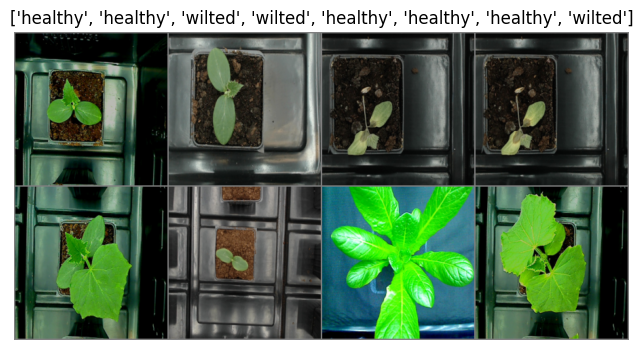

In [5]:
def show_batch(loader):
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images[:8], nrow=4)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize
    plt.title([class_names[l.item()] for l in labels[:8]])
    plt.axis('off')
    plt.show()

show_batch(train_loader)
#Below is the an example of the pictures after the transforms have been applied.


In [11]:
#Brings in the pretrained ResNet18 model and modifies it for our task.
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)
model = model.to(device)
#The current model you want to use, change if you made another model.
model_path="Plant-Wilting-Model_v2.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Loaded existing model weights.")
else:
    print("No saved model found. You need to train the model first.")


Loaded existing model weights.


In [12]:


import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
# Define the loss function and optimizer for training
# CrossEntropyLoss is suitable for multi-class classification tasks
# Adam optimizer is used to update only the parameters of the final fully connected layer (model.fc)

In [9]:
# Training Loop
from tqdm.notebook import tqdm
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Accuracy: {acc:.2f}%")
#Look at these beautiful progress bars!

Epoch 1/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 72.4409 - Accuracy: 90.03%


Epoch 2/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 28.9229 - Accuracy: 97.41%


Epoch 3/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 21.4124 - Accuracy: 98.00%


Epoch 4/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 16.5203 - Accuracy: 98.55%


Epoch 5/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 15.2751 - Accuracy: 98.59%


Epoch 6/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 14.0308 - Accuracy: 98.50%


Epoch 7/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 11.8415 - Accuracy: 98.94%


Epoch 8/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 10.8322 - Accuracy: 98.95%


Epoch 9/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 10.2810 - Accuracy: 98.93%


Epoch 10/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 9.9184 - Accuracy: 98.93%


In [10]:
#Model Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
#About 99% acuracy
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 99.53%


In [11]:
torch.save(model.state_dict(), "Plant-Wilting-Model_v2.pth") 

In [13]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return class_names[pred.item()]


In [14]:
#Example usage
print(predict_image(r"E:\peppermovement32124\Plant1\04-06-2024_06-58-Rep383.jpg"))

wilted


In [15]:
import pandas as pd
import re
from datetime import datetime
import os
import xlsxwriter

def extract_datetime_from_filename(filename):
    """Extract datetime from filename in MM-DD-YYYY_HH-MM format."""
    match = re.match(r"(\d{2}-\d{2}-\d{4})_(\d{2}-\d{2})", filename)
    if match:
        date_str = match.group(1)
        time_str = match.group(2)
        dt_str = f"{date_str} {time_str}"
        return datetime.strptime(dt_str, "%m-%d-%Y %H-%M")
    return None

def classify_images_in_folder(folder_path, excel_path="results.xlsx"):
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            label = 0 if predict_image(image_path) == "healthy" else 1
            dt = extract_datetime_from_filename(filename)
            results.append({'filename': filename, 'datetime': dt, 'label': label})
    
    df = pd.DataFrame(results)
    df = df.dropna(subset=['datetime'])
    df = df.sort_values(by='datetime')
    
    # Convert datetime to Excel serial number to match provided data
    df['datetime'] = df['datetime'].apply(
        lambda dt: (dt - datetime(1899, 12, 30)).total_seconds() / 86400
    )
    
    # Optional: Aggregate data by day to reduce clutter (uncomment if desired)
    # df['date'] = df['datetime'].apply(lambda x: int(x))
    # df = df.groupby('date').agg({'label': 'max'}).reset_index()
    # df['datetime'] = df['date'] + 0.5
    # df = df[['datetime', 'label']]
    
    df = df.drop(columns=['filename'])
    
    # Write to Excel using XlsxWriter
    writer = pd.ExcelWriter(excel_path, engine='xlsxwriter', datetime_format='mm/dd/yyyy hh:mm')
    df.to_excel(writer, sheet_name='Sheet1', index=False)
    
    # Get XlsxWriter objects
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    
    # Format datetime column explicitly
    date_format = workbook.add_format({'num_format': 'mm/dd/yyyy hh:mm'})
    worksheet.set_column('A:A', 15, date_format)
    
    # Create line chart
    chart = workbook.add_chart({'type': 'line'})
    chart.set_title({'name': 'Plant Health Over Time'})
    chart.set_x_axis({
        'name': 'Date/Time',
        'date_axis': True,
        'num_format': 'mm/dd/yyyy',
        'major_unit': 2,  # Ticks every 2 days
        'minor_unit': 0.5  # Minor ticks every 12 hours
    })
    chart.set_y_axis({
        'name': 'Health Status (0=Healthy, 1=Wilted)',
        'min': 0,
        'max': 1,
        'major_unit': 1,
        'major_gridlines': {'visible': False}
    })
    
    # Add data series
    max_row = len(df) + 1  # Account for header
    chart.add_series({
        'values': f'=Sheet1!$B$2:$B${max_row}',
        'categories': f'=Sheet1!$A$2:$A${max_row}',
        'line': {'color': "#158D39", 'width': 2},
        'marker': {
            'type': 'circle',
            'size': 5,
            'fill': {'color': "#00FF95"},
            'border': {'color': 'black'}
        }
    })
    
    # Insert chart
    worksheet.insert_chart('E5', chart, {'x_scale': 2.0, 'y_scale': 1.5})
    
    # Close workbook
    writer.close()
    return df

In [ ]:
#GUI For Non-Programmer use. Remember to run all of the previous code blocks sequantially before running this code block.
import tkinter as tk
from tkinter import filedialog
import customtkinter as ctk
import threading
# This GUi lag and appears to freeze while processing images, but it is actually still running. Give it about 30 seconds
def on_button_click():
    folder_path = filedialog.askdirectory(title="Select Folder Containing Images")
    if folder_path:
        status_label.configure(text="Processing images")
        excel_path = os.path.join(folder_path, "Health_results.xlsx")
        df = classify_images_in_folder(folder_path, excel_path)
        status_label.configure(text="Done!")
        print(f"Results saved to {excel_path}")
        print(df)

ctk.set_appearance_mode("dark")
root = ctk.CTk(fg_color="#3B3B3B")
root.title("Plant Wilt Detection")
root.geometry("1200x720")
status_label = ctk.CTkLabel(root, text="", font=ctk.CTkFont("Arial", 20), text_color="white")
status_label.pack(pady=20)
button = ctk.CTkButton(root, text="Select Folder for analizing", command=on_button_click, width=30, height=20, font=ctk.CTkFont("Arial", 24),  fg_color="lightblue", text_color="black", corner_radius=40)
button.pack(pady=(250,40), padx=40)
root.mainloop()

Results saved to C:/Users/dbrimmer/Downloads/Plant1_Peppermovement\Health_results.xlsx
         datetime  label
0    45372.373611      0
1    45372.415278      0
2    45372.456944      0
3    45372.498611      0
4    45372.540278      0
..            ...    ...
461  45391.581944      1
462  45391.623611      1
463  45391.665278      1
464  45391.706944      1
465  45391.748611      1

[466 rows x 2 columns]
